In [1]:
#Spark
import findspark
import pyspark

findspark.init()
sc = pyspark.SparkContext()

/usr/local/lib/python3.5/dist-packages/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [33]:
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F

import pandas as pd; import seaborn as sns
from datetime import datetime;
import json, sys, datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### AWS Athena query on `changesets` table: 

```sql
-- this is required because set_agg doesn't work in Athena, so it must be grouped by id here.... but I think it works

SELECT
  changesets.id,
  min(changesets.uid) uid, 
  min(changesets.user) user, 
  min(changesets.num_changes) num_changes,
--  min(highway_edits_2019.id) wayID, 
--  min(coordinates) coords,
  min(changesets.created_at) date,
  min(changesets.tags['imagery_used']) imagery_used,
  min(changesets.tags['comment']) comment
--  min(changesets.tags['hashtags']) hashtags
FROM highway_edits_2019
CROSS JOIN unnest(changeset_ids) AS t (cs)
JOIN changesets ON changesets.id = cs
WHERE changesets.tags is not null
GROUP BY changesets.id
```

In [34]:
#Start the sqlContext
sqlContext = pyspark.SQLContext(sc)

In [35]:
#Start with the since-2018 edits
schema = StructType() \
      .add("id",IntegerType(),True) \
      .add("uid",IntegerType(),True) \
      .add("user",StringType(),True) \
      .add("num_changes",IntegerType(),True) \
      .add("date",StringType(),True) \
      .add("imagery_used",StringType(),True) \
      .add("comment",StringType(),True) \
      .add("created_by",StringType(),True)
#       .add("min_lat",FloatType(),True) \
#       .add("max_lat",FloatType(),True) \
#       .add("min_lon",FloatType(),True) \
#       .add("max_lon",FloatType(),True)
    
changesets = sqlContext.read.format("csv") \
                .option("header",True) \
                .schema(schema) \
                .load("csv/highway-updates-2019.csv")

In [36]:
changesets.dtypes

[('id', 'int'),
 ('uid', 'int'),
 ('user', 'string'),
 ('num_changes', 'int'),
 ('date', 'string'),
 ('imagery_used', 'string'),
 ('comment', 'string'),
 ('created_by', 'string')]

In [37]:
changesets.tail(1)

[Row(id=69685741, uid=8847254, user='Roméo', num_changes=203, date='2019-04-29 08:22:43.000', imagery_used='Custom (https://{switch:a,b,c,d}.tiles.mapbox.com/v4/digitalglobe.0a8e44ba/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZGlnaXRhbGdsb2JlIiwiYSI6ImNqZGFrZ3pjczNpaHYycXFyMGo0djY3N2IifQ.90uebT4-ow1uqZKTUrf6RQ);.gpx data file', comment='#hotosm-project-4408 #IRD_FR #PIVOTMadagascar Residential areas, isolated dwellings and roads mapping.', created_by=None)]

In [38]:
#Convert the date string to a real date
changesets = changesets.withColumn('date',F.to_timestamp(changesets.date, 'yyyy-MM-dd HH:mm:ss.SSS'))

In [39]:
#Extract just the year for easier grouping
changesets = changesets.withColumn('year',F.year(F.col('date')))

In [40]:
#Filter for only rows with imagery
changesets_with_imagery = changesets.filter(F.col('imagery_used').isNotNull())

In [41]:
changesets_with_imagery.count()

2409448

In [42]:
def imagery_classifier(imagery_used_string):
    lower_string = imagery_used_string.lower()

    if 'bing' in lower_string:
        return 'microsoft'

    if 'esri' in lower_string:
        return 'esri'

    if 'mapbox' in lower_string:
        return 'mapbox'

    if 'maxar' in lower_string or 'digitalglobe' in lower_string:
        return 'maxar'

    if 'bdortho ign' in lower_string:
        return 'BDOrtho IGN'

    if 'pnoa spain' in lower_string:
        return 'PNOA Spain'

    else:
        return 'unclassified'

    return res

from pyspark.sql.types import StringType
imagery_classifier_udf = F.udf(lambda z: imagery_classifier(z), StringType())

In [43]:
changesets_with_imagery = changesets_with_imagery.withColumn('source', imagery_classifier_udf(F.col('imagery_used')))

In [44]:
changesets_with_imagery.take(3)

[Row(id=83902746, uid=2191020, user='velomeloman', num_changes=154, date=datetime.datetime(2020, 4, 21, 22, 2, 1), imagery_used='Bing aerial imagery;.gpx data file', comment='Добавлен магазин и кафе. Уточнены дороги.', created_by=None, year=2020, source='microsoft'),
 Row(id=67176028, uid=5410922, user='reza valipoor', num_changes=191, date=datetime.datetime(2019, 2, 13, 21, 46, 43), imagery_used='Bing aerial imagery', comment='OK', created_by=None, year=2019, source='microsoft'),
 Row(id=82541805, uid=3172019, user='nurdafur', num_changes=217, date=datetime.datetime(2020, 3, 23, 21, 33, 32), imagery_used='Kanton Thurgau, Orthofoto2017 RGB', comment='Velorouten, Strassen, Wege, Gebäude, Surface, Pois zugefügt, angepasst', created_by=None, year=2020, source='unclassified')]

In [45]:
# This is the number of changesets we'll have to ignore for parsing errors
changesets_with_imagery.filter(F.col('year').isNull()).count()

17

In [46]:
gb_year = changesets_with_imagery.filter(F.col('year').isNotNull()) \
   .groupby(['year','source']).agg(
      F.countDistinct('uid'),
      F.sum('num_changes'),
      F.count('id')).toPandas()
gb_year.head(3)

,year,source,count(uid),sum(num_changes),count(id)
0,2020,PNOA Spain,1079,2027143,13606
1,2020,esri,7923,20381754,160696
2,2020,unclassified,10688,16529904,126594


In [47]:
# A little cleaning
gb_year.year = gb_year.year.apply(int)

In [48]:
gb_year.head(3)

,year,source,count(uid),sum(num_changes),count(id)
0,2020,PNOA Spain,1079,2027143,13606
1,2020,esri,7923,20381754,160696
2,2020,unclassified,10688,16529904,126594


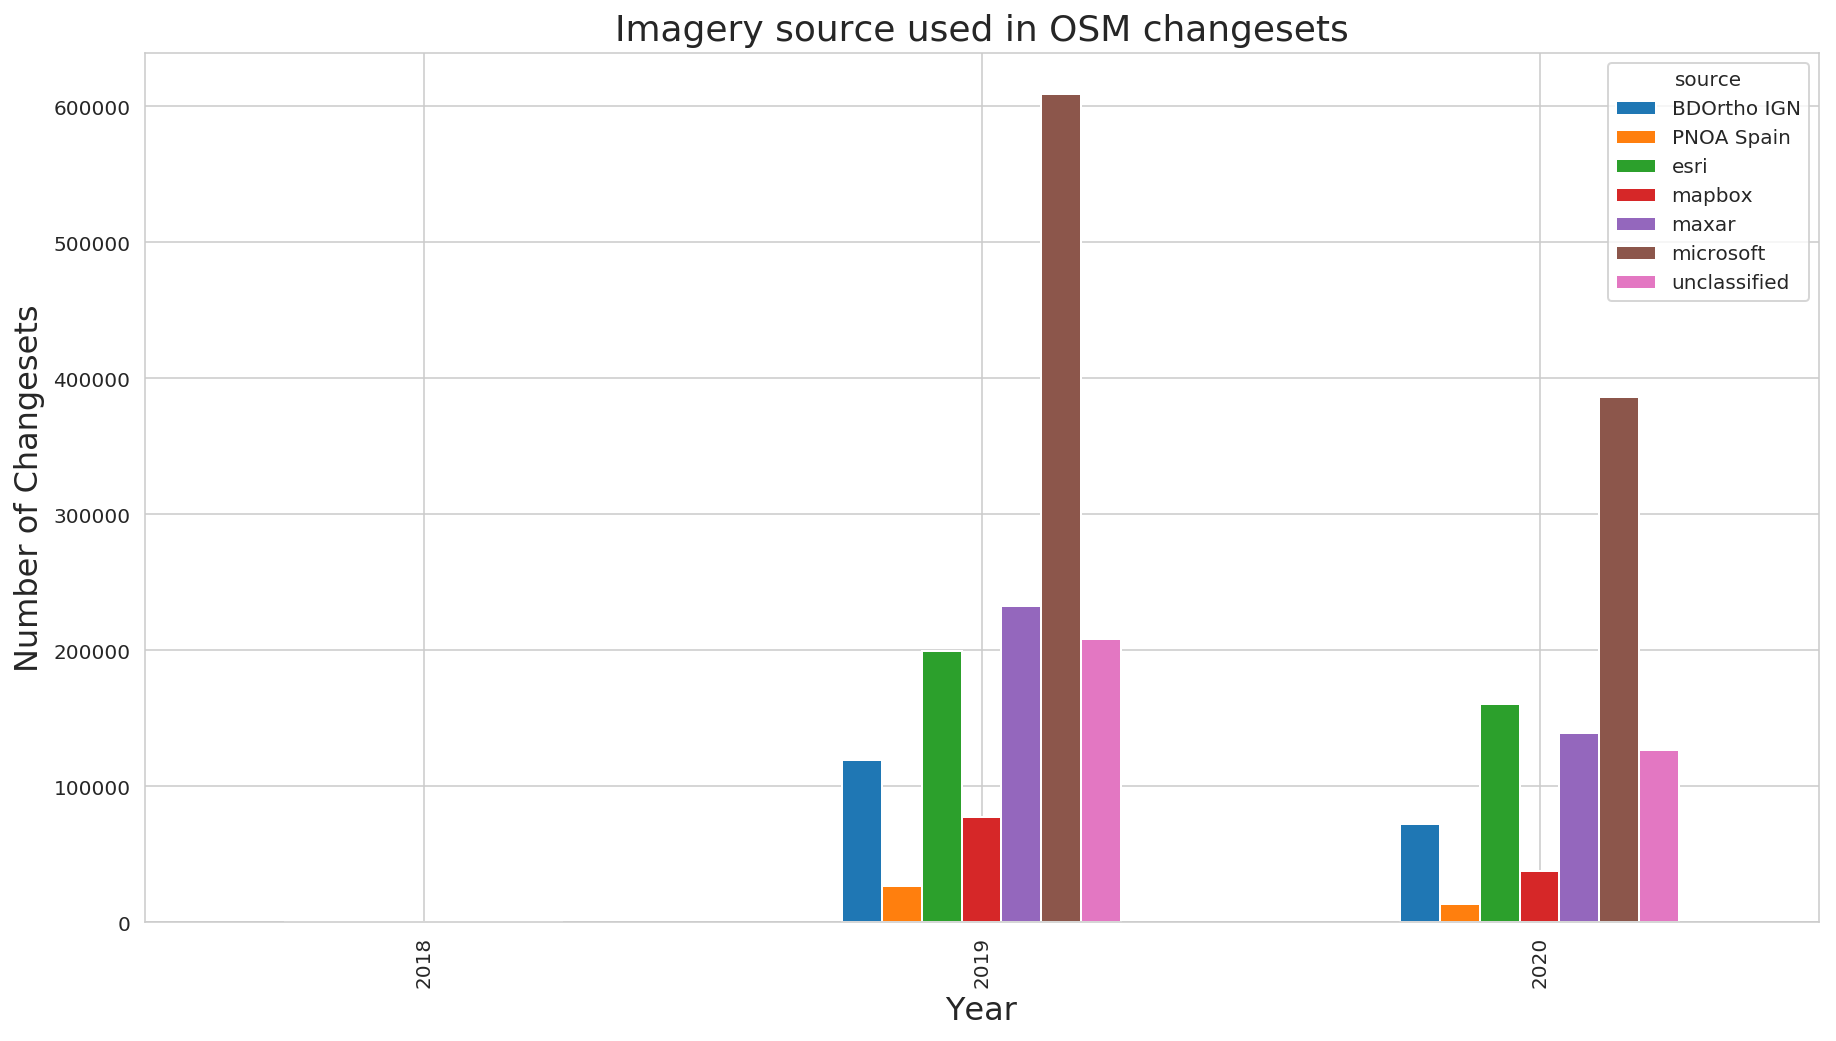

In [49]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['count(id)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Changesets',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

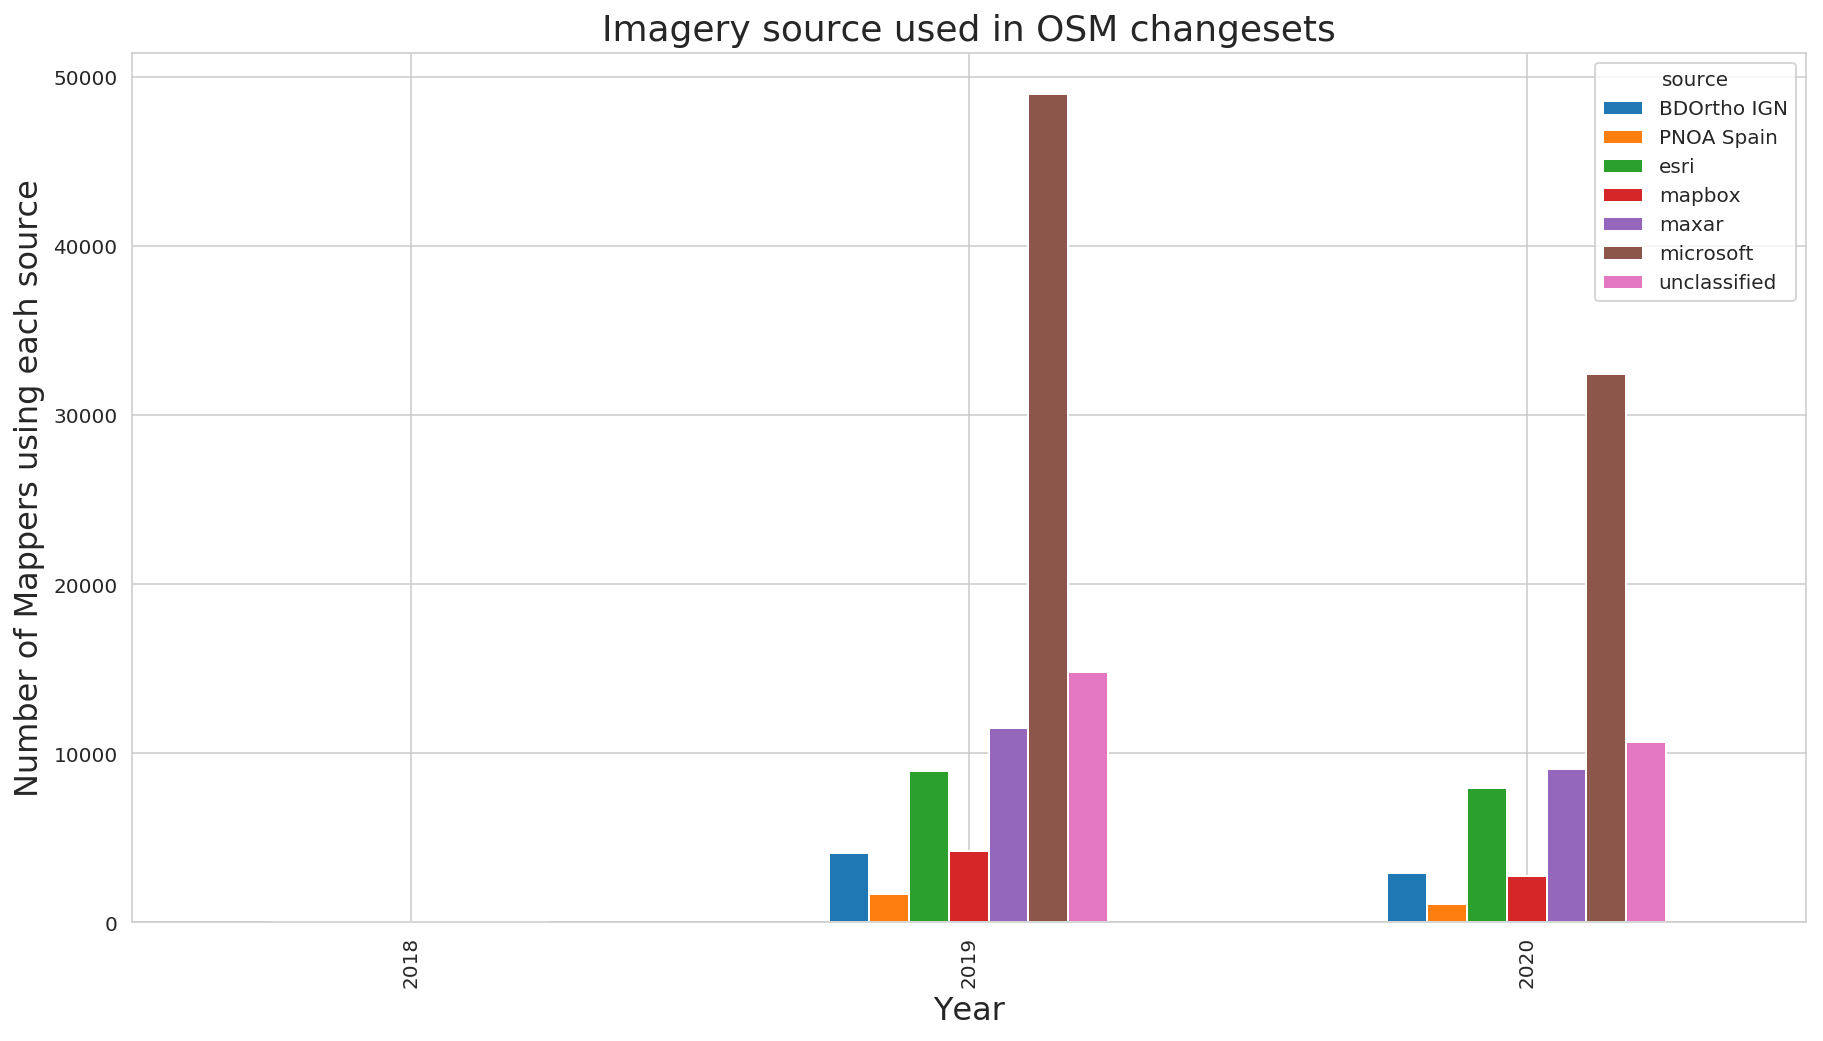

In [50]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['count(uid)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Mappers using each source',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

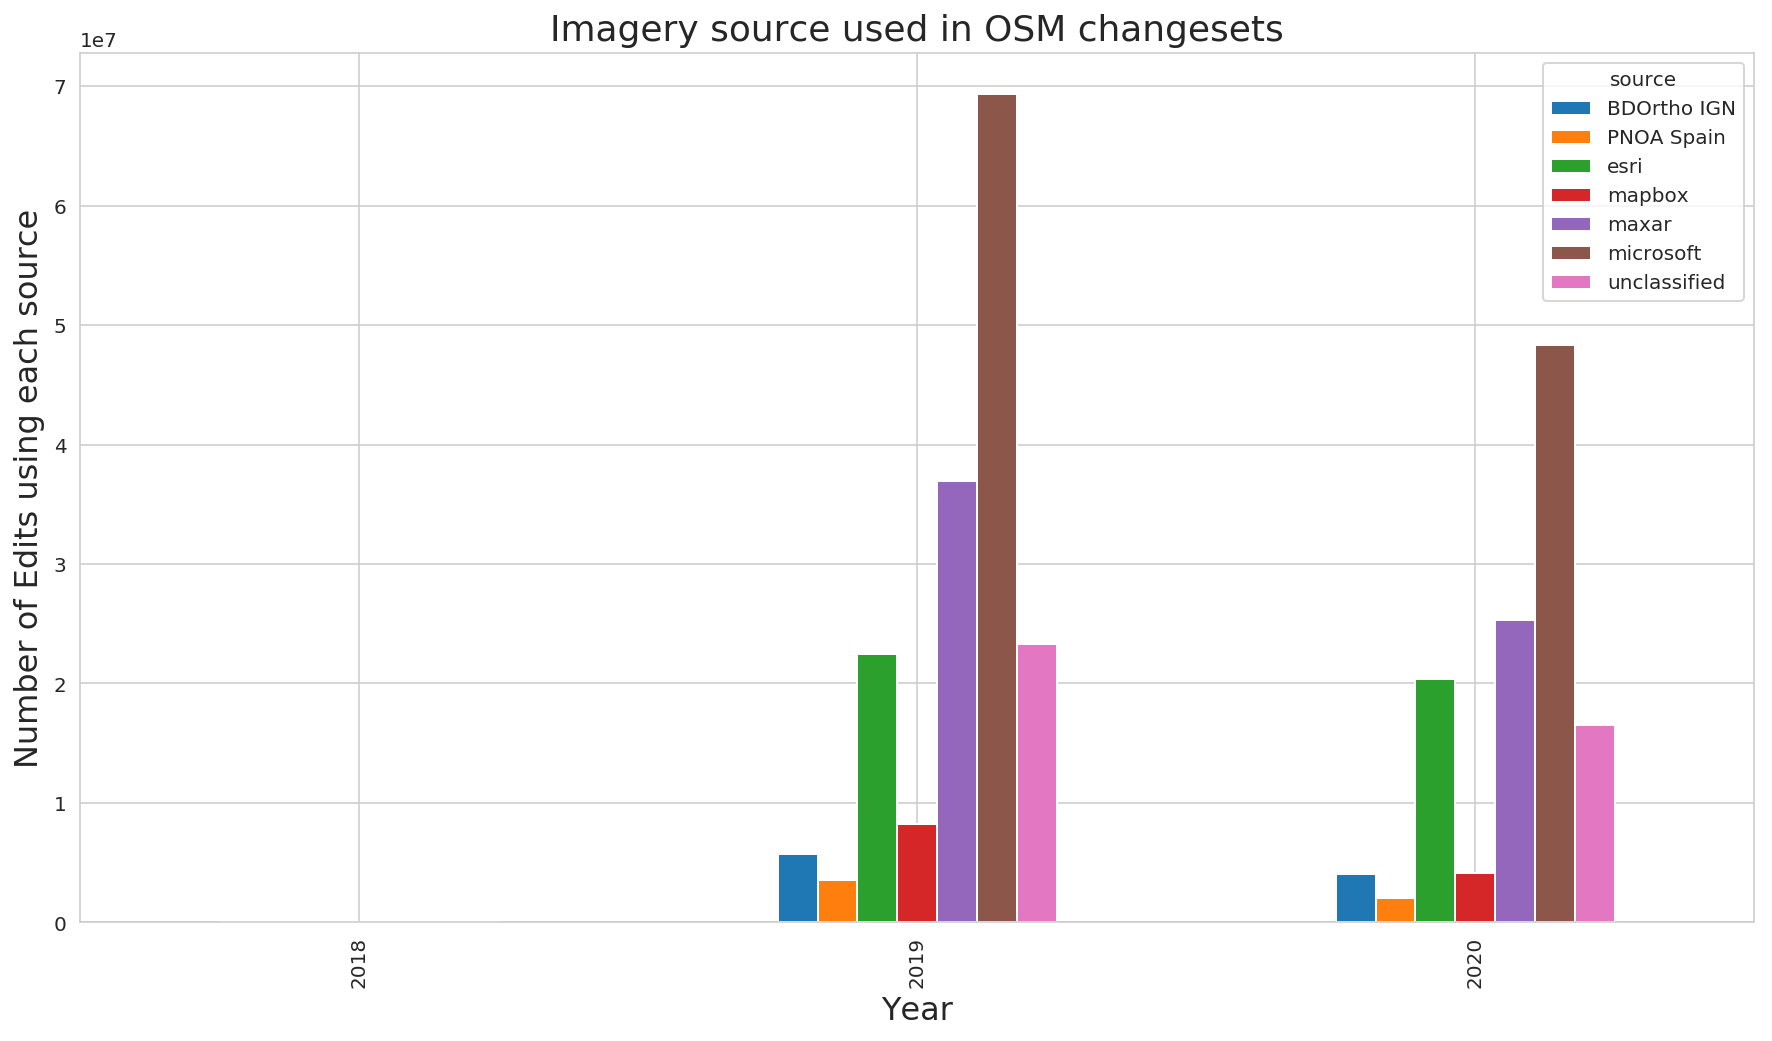

In [51]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['sum(num_changes)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Edits using each source',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

<br><br><br><br><hr>

In [ ]:
#What's 'unclassified'?
other_counts = changesets_with_imagery.filter(F.col('source').isin(
    ['unclassified'])
).groupBy('imagery_used').agg(
    F.count('id')).sort(
        F.desc('count(id)')).toPandas()

In [36]:
other_counts.head(50)

,imagery_used,count(id)
0,OpenStreetMap (Standard),369747
1,Geoportal.gov.pl (Orthophotomap),342701
2,Geoportal 2: Orthophotomap (aerial image),224958
3,basemap.at Orthofoto,148612
4,PDOK aerial imagery Beeldmateriaal.nl 25cm latest,133104
5,Bavaria (80 cm),98995
6,Lithuania - NŽT ORT10LT,91863
7,SDFE aerial imagery,72715
8,"Custom (https://{switch:services,server}.arcgi...",67193
9,Japan GSI Standard Map,67187
